# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    


# Task 2: Preprocess Data

In [2]:
#CIFAR-10 datset has 60k training and 10k test eg and 10 labels we use a subset of this dataset for data corresponding to only 3 labels.
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False) #to shuffle the indices order arg1:list of available values, arg2:number of values we want back, arg3:all retuned values should be unique
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y) #convert labels 0,1,2 to one hot encoded format
    #in DL models labels must always be in one hot encoded format so as to be able to chose from a variety of entropy loss functions.
    
    return x, y

In [3]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.cifar10.load_data()
(x_train, y_train)=get_three_classes(x_train, y_train)
(x_test,y_test)=get_three_classes(x_test,y_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

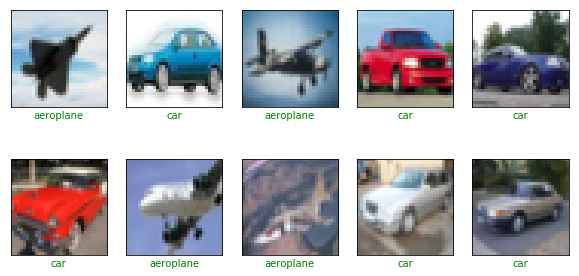

In [19]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):   #x,y are inputs and p is prediciton if any
    indices=np.random.choice(range(x.shape[0]), 10, replace=False)  #we only want 10 random examples from list of all indices and they will be unique 
    
    x=x[indices]
    y=y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        #color of label green if prediction right else red
        col='green' if np.argmax(y[i])==np.argmax(p[i]) else 'red'  #np.argmax will reurn 0,1 or 2 from one hot econded format of each label indicating which of the three classes it is
        plt.xlabel(class_names[np.argmax(y[i])],color=col)
    plt.show()   
    
#lets test it on training examples
show_random_examples(x_train, y_train, y_train)

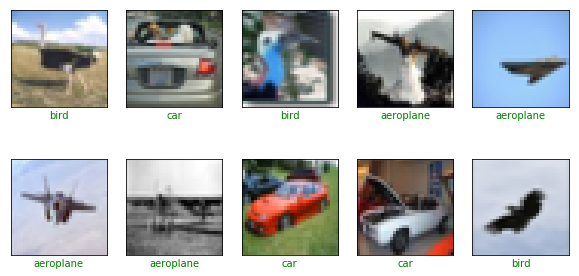

In [20]:
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same')) #3 kernels and row,columns size remains same
        model.add(BatchNormalization()) #to ensure there is not much covariance shift from output of preceeding layer
        model.add(Conv2D(num_filters, 3, activation='relu')) #padding is valid hre and so row and column size not same
        model.add(MaxPooling2D(pool_size=2)) #reduce row,column dimensions to half value
        model.add(Dropout(0.5))  #for every example randomly 50% of nodes are inactivated
        
        
    model=tf.keras.models.Sequential() #instantiate a model
    model.add(Input(shape=(32,32,3))) #input layer and we know size of images from above
    
    add_conv_block(model, 32) 
    add_conv_block(model, 64)
    add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))  #output layer
    
    model.compile(
                  loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
    )
    
    return model

model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

# Task 5: Train the Model

In [8]:
#what early stopping does is when given a metric it checks till whenn model is improving on metric and as soon as model stops improving metric it stops training
#thus hepls avoid underfitting and overfitting as val_score or val_accuracy when stops improving indicates that model is performing 
#as well as it can on test/dev set with current parameters and further training will cause it to overfit training data

h=model.fit(x_train/255., y_train,
           validation_data=(x_test/255., y_test),  #val here refers to test data
           epochs=10,   #randomly set value,will actually be decided based on EarlyStopping callback
           batch_size=32,  #mini batch gradient descent
           callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3), #every 3 epochs check if val_accuracy is improving and if it doesnt stop training
               tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',save_best_only=True, #save the best performing model
                       save_weights_only=False,monitor='val_accuracy')
                                                  ]
           )  

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 156s 10ms/sample - loss: 0.7758 - accuracy: 0.7071 - val_loss: 1.4845 - val_accuracy: 0.4860
Epoch 2/10
15000/15000 [==============================] - 142s 9ms/sample - loss: 0.5248 - accuracy: 0.7902 - val_loss: 0.5521 - val_accuracy: 0.7840
Epoch 3/10
15000/15000 [==============================] - 139s 9ms/sample - loss: 0.4616 - accuracy: 0.8157 - val_loss: 0.9086 - val_accuracy: 0.6670
Epoch 4/10
15000/15000 [==============================] - 135s 9ms/sample - loss: 0.4175 - accuracy: 0.8371 - val_loss: 0.3413 - val_accuracy: 0.8653
Epoch 5/10
15000/15000 [==============================] - 136s 9ms/sample - loss: 0.3839 - accuracy: 0.8519 - val_loss: 0.3313 - val_accuracy: 0.8683
Epoch 6/10
15000/15000 [==============================] - 134s 9ms/sample - loss: 0.3611 - accuracy: 0.860

# Task 6: Final Predictions

In [9]:
#using latest model i.e. after 10th epoch
model.evaluate(x_test/255.,y_test,batch_size=32,verbose=1)

3000/3000 [==============================] - 4s 1ms/sample - loss: 0.3077 - accuracy: 0.87831s - los


[0.3076898537874222, 0.87833333]

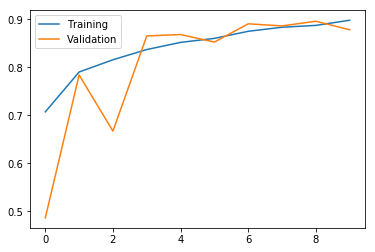

In [10]:
accs=h.history['accuracy']
val_accs=h.history['val_accuracy']
plt.plot(range(len(accs)),accs,label='Training')
plt.plot(range(len(val_accs)),val_accs,label='Validation')
plt.legend()
plt.show()

#no significant overfitting and both accuracies are on the rise so could increase max epochs or change batch_size,etc to get an even better model.

In [16]:
#could use the model obtained after 10th epoch but sometimes a more efficient model may have been obtained in earlier epochs so to use them
model=tf.keras.models.load_model('models/model_0.896.h5')
#this is 9th epoch model which gives best result for val_data so we use this for prediction

ValueError: You are trying to load a weight file containing 10 layers into a model with 0 layers.

In [17]:
preds=model.predict(x_test/255.)

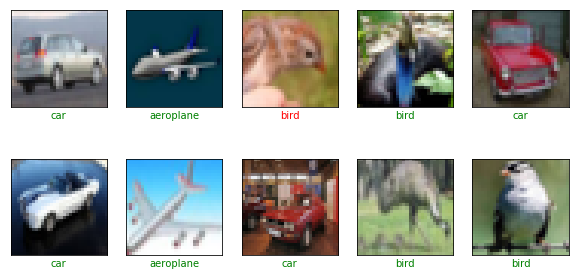

In [21]:
show_random_examples(x_test,y_test,preds)